✅ Voltage traces saved to voltage___traces2345.csv


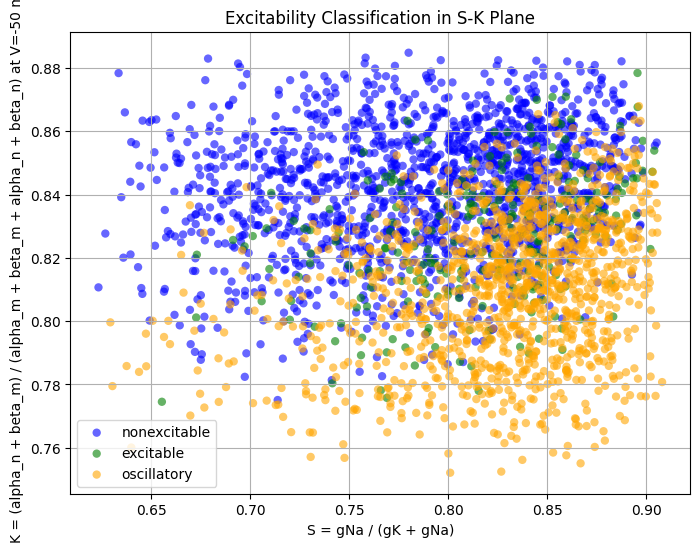

In [10]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint

# 1. Baseline Parameters
BASE_PARAMS = {
    "Cm":   1.0,
    "gNa":  120.0,
    "gK":   36.0,
    "gL":   0.3,
    "ENa":  50.0,
    "EK":  -77.0,
    "EL":  -54.387
}

# 2. Parameter Ranges
PARAM_RANGES = {
    "Cm":  (0.8, 1.5),
    "ENa": (30.0, 54.0),
    "EK":  (-79.0, -74.0),
    "EL":  (-61.0, -43.0),
    "gNa": (80.0, 260.0),
    "gK":  (26.0, 49.0),
    "gL":  (0.1, 0.5)
}

# 3. Gating Rates
def alpha_m(V):
    return np.where(np.abs(V + 40) < 1e-7, 1.0, 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10)))
def beta_m(V):
    return 4.0 * np.exp(-(V + 65) / 18)
def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)
def beta_h(V):
    return 1.0 / (1 + np.exp(-(V + 35) / 10))
def alpha_n(V):
    return np.where(np.abs(V + 55) < 1e-7, 0.1, 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10)))
def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)

# 4. HH Model ODEs
def hh_model(state, t, params, rate_scales, I_ext_func):
    V, m, h, n = state
    Cm, gNa, gK, gL, ENa, EK, EL = [params[k] for k in ["Cm", "gNa", "gK", "gL", "ENa", "EK", "EL"]]

    a_m = rate_scales["alpha_m"] * alpha_m(V)
    b_m = rate_scales["beta_m"] * beta_m(V)
    a_h = rate_scales["alpha_h"] * alpha_h(V)
    b_h = rate_scales["beta_h"] * beta_h(V)
    a_n = rate_scales["alpha_n"] * alpha_n(V)
    b_n = rate_scales["beta_n"] * beta_n(V)

    I_Na = gNa * (m**3) * h * (V - ENa)
    I_K  = gK * (n**4) * (V - EK)
    I_L  = gL * (V - EL)

    dVdt = (I_ext_func(t) - I_Na - I_K - I_L) / Cm
    dmdt = a_m * (1 - m) - b_m * m
    dhdt = a_h * (1 - h) - b_h * h
    dndt = a_n * (1 - n) - b_n * n

    return [dVdt, dmdt, dhdt, dndt]

# 5. External Current
def I_ext_func(t, I_stim=0.7, t_stim_on=50.0, pulse_width=1.0):
    return I_stim if (t_stim_on <= t < t_stim_on + pulse_width) else 0.0

# 6. Simulation
def simulate_HH(params, rate_scales, dt=0.01, tmax=150.0,
                I_stim=0.7, t_stim_on=50.0, pulse_width=1.0):
    t = np.arange(0, tmax, dt)
    V0 = -65.0
    state0 = [
        V0,
        alpha_m(V0) / (alpha_m(V0) + beta_m(V0)),
        alpha_h(V0) / (alpha_h(V0) + beta_h(V0)),
        alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
    ]

    sol = odeint(
        hh_model, state0, t,
        args=(params, rate_scales,
              lambda time: I_ext_func(time, I_stim, t_stim_on, pulse_width))
    )
    return t, sol[:, 0]

# 7. Spike Counting
def count_spikes(V_trace, threshold=0.0):
    return len(np.where((V_trace[:-1] < threshold) & (V_trace[1:] >= threshold))[0])

def classify_outcome(V_trace, threshold=0.0):
    n_spikes = count_spikes(V_trace, threshold)
    if n_spikes == 0:
        return "nonexcitable"
    elif n_spikes == 1:
        return "excitable"
    else:
        return "oscillatory"

# 8. S and K calculations
def compute_S(params):
    return params["gNa"] / (params["gK"] + params["gNa"] + 1e-9)

def compute_K(rate_scales, Vref=-50.0):
    am, bm = alpha_m(Vref), beta_m(Vref)
    an, bn = alpha_n(Vref), beta_n(Vref)

    am_eff = rate_scales["alpha_m"] * am
    bm_eff = rate_scales["beta_m"] * bm
    an_eff = rate_scales["alpha_n"] * an
    bn_eff = rate_scales["beta_n"] * bn

    return (an_eff + bm_eff) / (am_eff + bm_eff + an_eff + bn_eff + 1e-9)

# 9. Run Simulations and Save Voltage Traces
def run_paper_style_sims(n_samples=5000, dt=0.01, tmax=150.0,
                         I_stim=0.7, t_stim_on=50.0, pulse_width=1.0,
                         Vref=-56.0):
    S_vals, K_vals = np.zeros(n_samples), np.zeros(n_samples)
    outcomes = np.empty(n_samples, dtype=object)

    t_vec = np.arange(0, tmax, dt)
    all_traces = []
    colnames = []

    for i in range(n_samples):
        params = {k: np.random.uniform(*PARAM_RANGES[k]) for k in PARAM_RANGES}
        rate_scales = {k: np.random.uniform(0.75, 1.25) for k in
                       ["alpha_m", "beta_m", "alpha_h", "beta_h", "alpha_n", "beta_n"]}

        t, V_trace = simulate_HH(params, rate_scales, dt, tmax,
                                 I_stim, t_stim_on, pulse_width)

        outcome = classify_outcome(V_trace)
        outcomes[i] = outcome
        S_vals[i] = compute_S(params)
        K_vals[i] = compute_K(rate_scales, Vref)

        group = {"nonexcitable": 0, "excitable": 1, "oscillatory": 2}[outcome]
        all_traces.append(V_trace)
        colnames.append(f"neuron_{i}_group{group}")

    # Save voltage traces to CSV
    df = pd.DataFrame(np.array(all_traces).T, index=t_vec, columns=colnames)
    df.index.name = "time"
    df.to_csv("voltage___traces2345.csv")
    print("✅ Voltage traces saved to voltage___traces2345.csv")

    return S_vals, K_vals, outcomes

# 10. Main Execution and Plot
S_vals, K_vals, outcomes = run_paper_style_sims(
    n_samples=3000,   # number of the simulated cells
    dt=0.01,           #step_size
    tmax=150.0,        # Maximum time period (millisecond)
    I_stim=0.7,        # External current injection(microamper)
    t_stim_on=50.0,    # time where current is injected
    pulse_width=1.0,   # The time that current should inject (50ms to 51ms)
    Vref=-56.0         # Reference membrane potential(millivoltage)
)

# Plotting the results
plt.figure(figsize=(8, 6))
color_map = {"nonexcitable": "blue", "excitable": "green", "oscillatory": "orange"}
for ctype in color_map:
    idx = (outcomes == ctype)
    plt.scatter(S_vals[idx], K_vals[idx], c=color_map[ctype],
                label=ctype, alpha=0.6, edgecolors='none')

plt.xlabel("S = gNa / (gK + gNa)")
plt.ylabel("K = (alpha_n + beta_m) / (alpha_m + beta_m + alpha_n + beta_n) at V=-50 mV")
plt.title("Excitability Classification in S-K Plane")
plt.grid(True)
plt.legend()
plt.show()


Applying the Wavelet Scattering Transform

In [4]:
!pip install kymatio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 8.2 MB/s eta 0:00:00


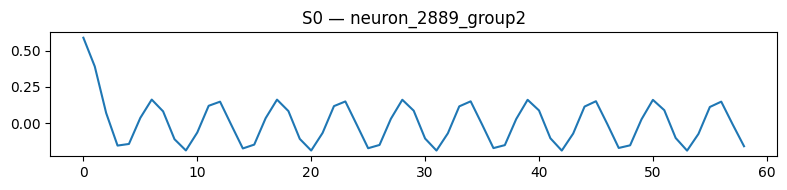

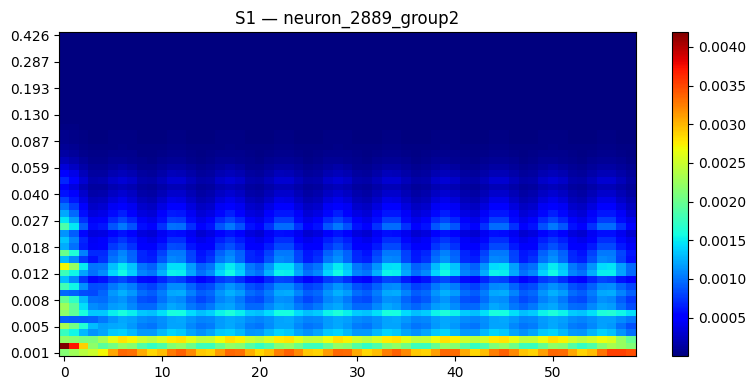

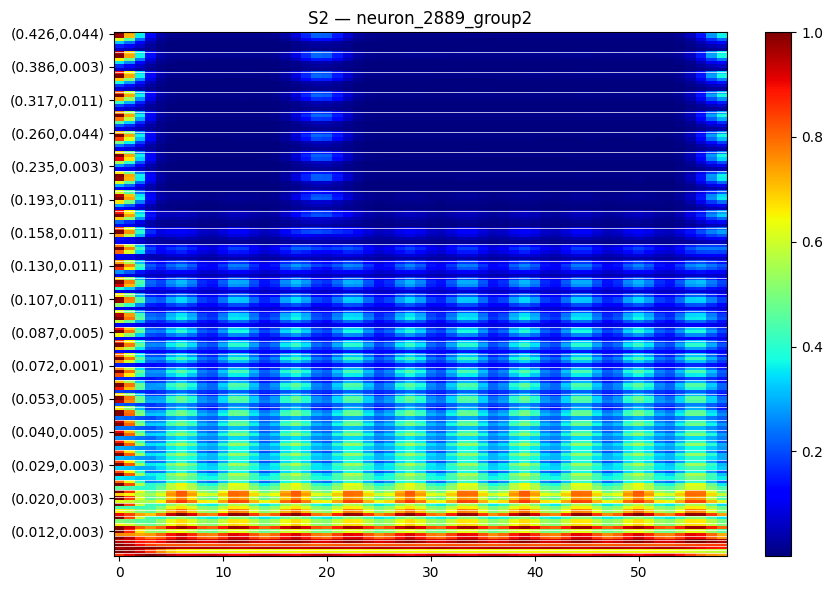

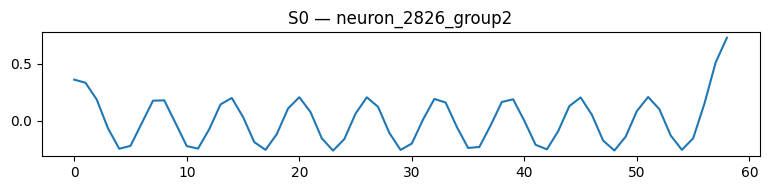

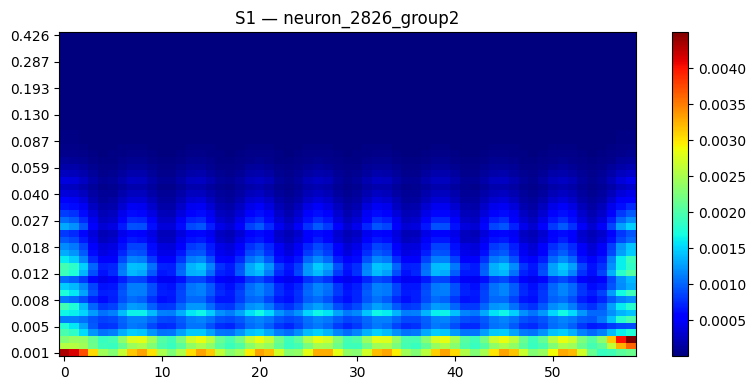

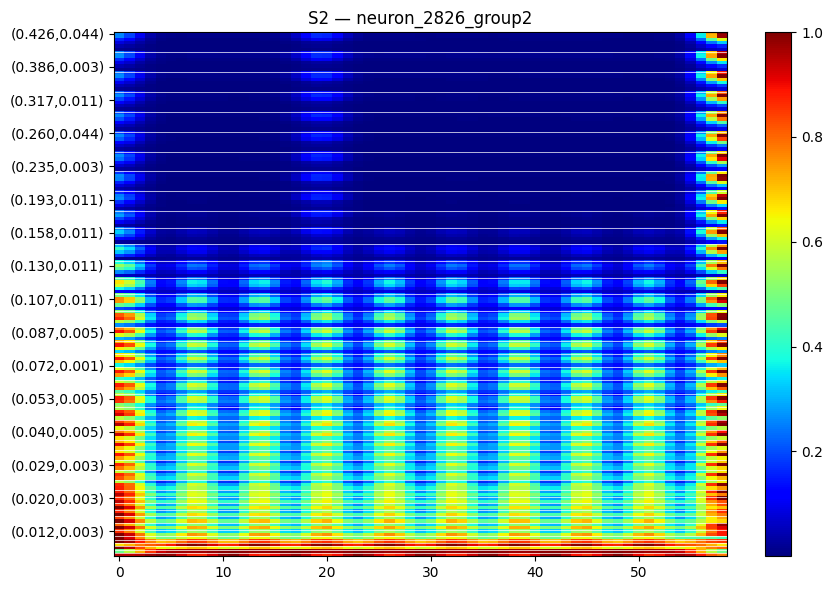

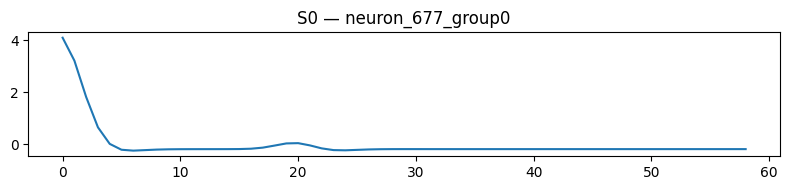

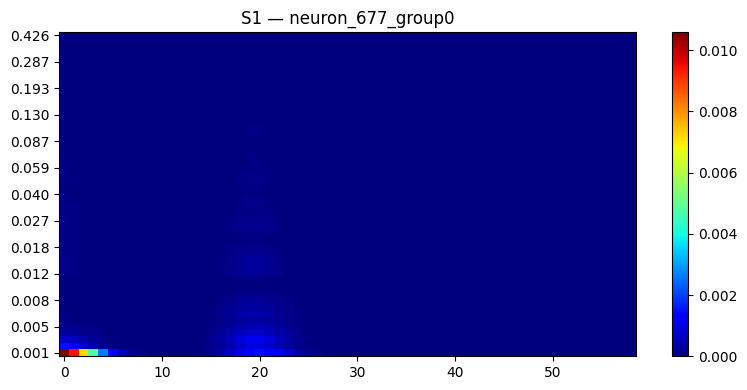

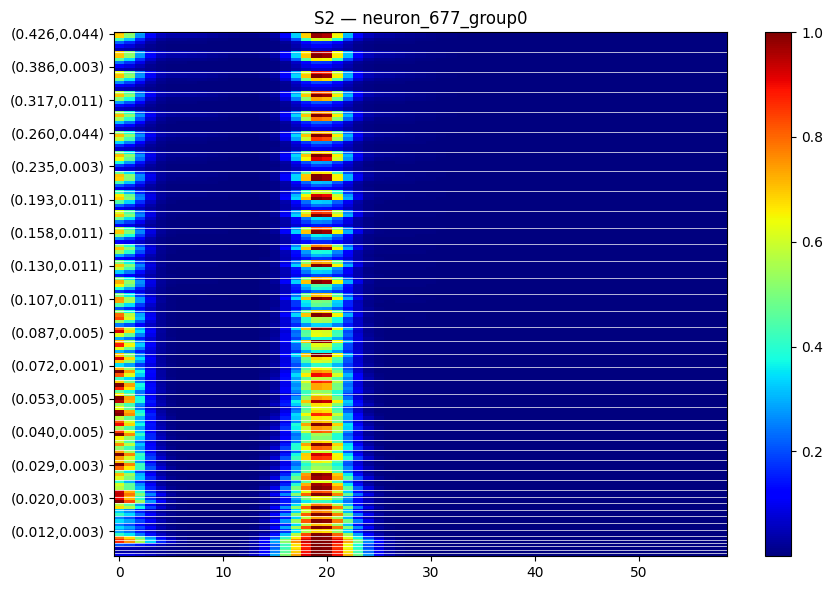

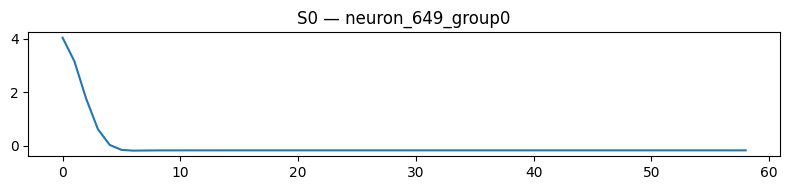

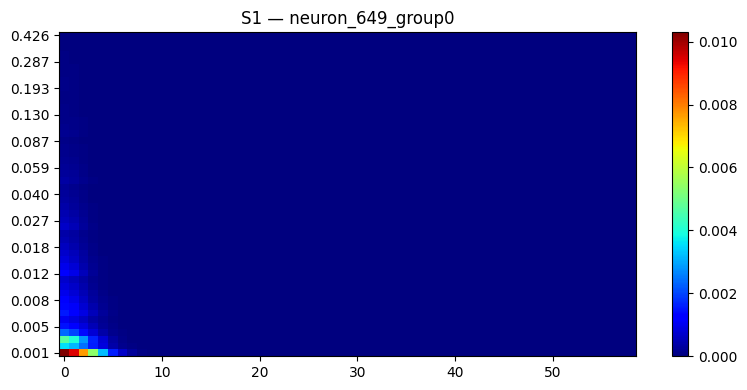

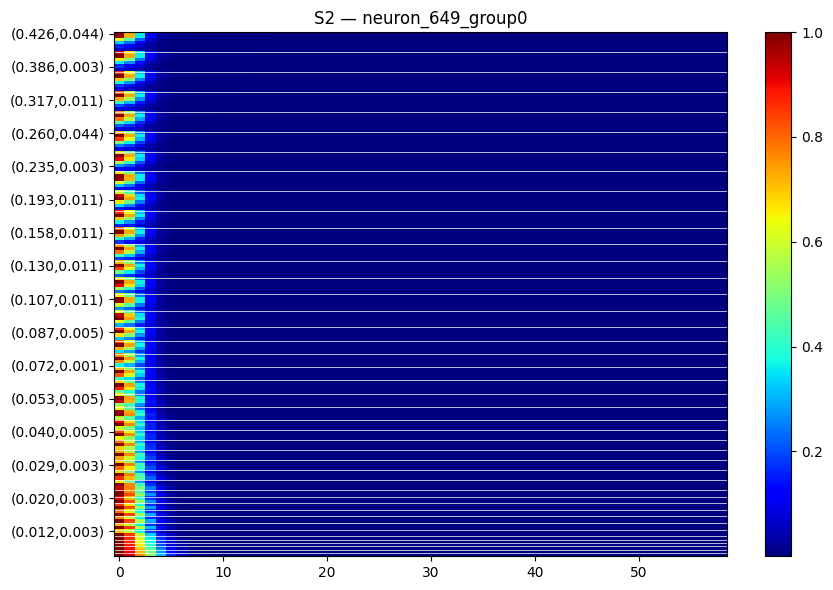

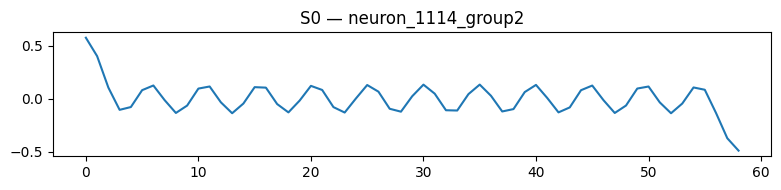

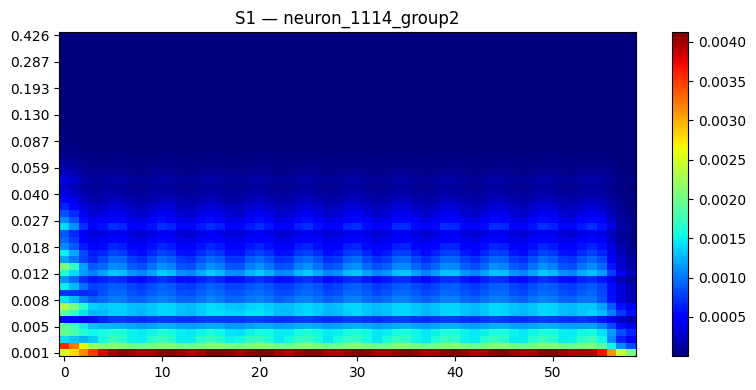

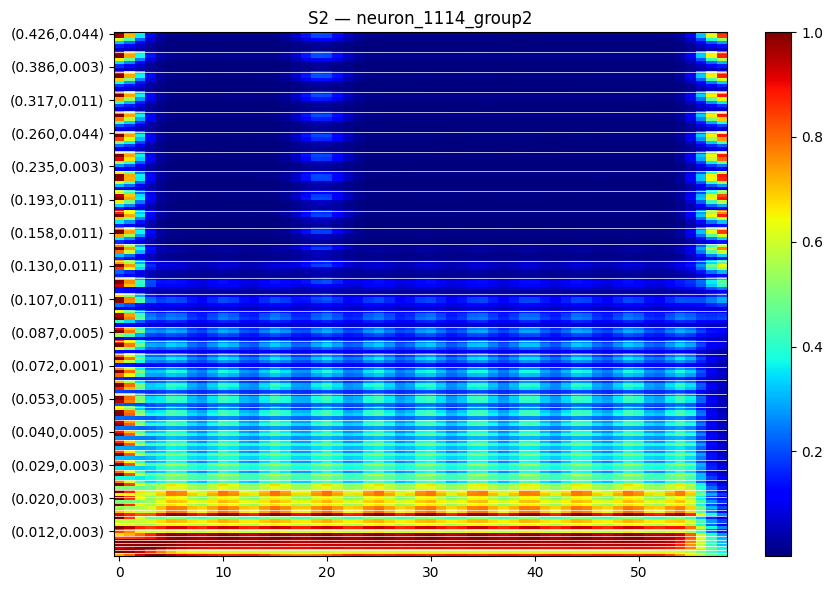

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from kymatio.torch import Scattering1D
import random

CSV_PATH = "voltage___traces2345.csv"
J = 8
Q = 7
OVERSAMPLING = 0
MAX_ORDER = 2
N_PLOTS = 5

df = pd.read_csv(CSV_PATH)
names = df.columns[1:]
data = df[names].T.to_numpy().astype(np.float32)

N, L = data.shape
means = data.mean(axis=1, keepdims=True)
stds = data.std(axis=1, keepdims=True)
stds[stds == 0] = 1
data = (data - means) / stds

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scattering = Scattering1D(J=J, shape=L, Q=Q, oversampling=OVERSAMPLING, max_order=MAX_ORDER).to(device)
meta = scattering.meta()

order = meta["order"]
j_all = meta["j"]
xi_all = meta["xi"]

order0 = np.where(order == 0)[0]
order1 = np.where(order == 1)[0]
order2 = np.where(order == 2)[0]

xi1 = xi_all[order1, 0]
sort1 = np.argsort(xi1)[::-1]
xi1_sorted = xi1[sort1]

xi_pairs = xi_all[order2]
perm_S2 = np.lexsort((-xi_pairs[:, 1], -xi_pairs[:, 0]))
order2_sorted = order2[perm_S2]
xi_pairs_sorted = xi_pairs[perm_S2]

parent_change_rows = np.where(np.diff(xi_pairs_sorted[:, 0]) != 0)[0] + 1

x_torch = torch.from_numpy(data).unsqueeze(1).float().to(device)
with torch.no_grad():
    Sx = scattering(x_torch)

Sx = Sx.cpu().numpy()
if Sx.ndim == 4:
    Sx = Sx[:, 0]
if Sx.shape[1] != len(order):
    Sx = np.transpose(Sx, (0, 2, 1))

S0 = Sx[:, order0, :]
S1_unsorted = Sx[:, order1, :]
S2_unsorted = Sx[:, order2, :]

S1 = S1_unsorted[:, sort1, :]
S2 = S2_unsorted[:, perm_S2, :]

np.save("GPU_WST_full.npy", Sx)
np.save("GPU_WST_S1.npy", S1)
np.save("GPU_WST_S2.npy", S2)

np.savez(
    "GPU_WST_S1S2_both.npz",
    names=np.array(names),
    S1=S1,
    S2=S2,
    xi1=xi1_sorted,
    xi_pairs=xi_pairs_sorted
)

rand_indices = random.sample(range(N), min(N_PLOTS, N))

for idx in rand_indices:
    name = names[idx]

    plt.figure(figsize=(8, 2))
    plt.plot(S0[idx, 0])
    plt.title(f"S0 — {name}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.imshow(S1[idx], aspect="auto", origin="upper", cmap="jet")
    ax = plt.gca()
    K = len(xi1_sorted)
    step = max(1, K // 10)
    tick_pos = np.arange(0, K, step)
    ax.set_yticks(tick_pos)
    ax.set_yticklabels([f"{xi1_sorted[p]:.3f}" for p in tick_pos])
    plt.title(f"S1 — {name}")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    S2n = S2[idx].copy()
    start = 0
    for brk in list(parent_change_rows) + [S2n.shape[0]]:
        block = S2n[start:brk]
        d = np.max(block)
        if d > 0:
            S2n[start:brk] = block / d
        start = brk

    plt.figure(figsize=(9, 6))
    plt.imshow(S2n, aspect="auto", origin="upper", cmap="jet")
    ax = plt.gca()
    for r in parent_change_rows:
        ax.axhline(y=r - 0.5, color="white", linewidth=0.5)
    npaths = S2n.shape[0]
    step = max(1, npaths // 15)
    ticks = np.arange(0, npaths, step)
    ax.set_yticks(ticks)
    ax.set_yticklabels([f"({xi_pairs_sorted[r,0]:.3f},{xi_pairs_sorted[r,1]:.3f})" for r in ticks])
    plt.title(f"S2 — {name}")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


Futher Dimontionality reduction by Variational of Autoencoders(CNN based)

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler

print("--- Loading GPU_WST_S1S2_both.npz ---")

npz = np.load("/content/GPU_WST_S1S2_both.npz", allow_pickle=True)
S1 = npz["S1"]    # (N, n1, T)

print("S1 shape:", S1.shape)

N, n1, T = S1.shape

# Flatten ONLY S1
S = S1.reshape(N, n1*T)
print("Flattened S1:", S.shape)

# Scale 0–1
scaler = MinMaxScaler()
S_scaled = scaler.fit_transform(S)

input_dim_original = S_scaled.shape[1]
target_dim = max(1024, input_dim_original)   # allow larger than 1664 if needed
padding_needed = target_dim - input_dim_original

S_padded = np.pad(
    S_scaled,
    ((0,0),(0,padding_needed)),
    mode='constant',
    constant_values=0
)

print(f"Padded {input_dim_original} → {target_dim}")

S_tensor = torch.from_numpy(S_padded[:,None,:]).float()
print("Final tensor:", S_tensor.shape)


# ----------------------------
#  Train / Val Split
# ----------------------------
N = S_tensor.size(0)
n_train = int(0.7*N)
n_val   = int(0.15*N)
n_test  = N - n_train - n_val

train_ds, val_ds, test_ds = random_split(
    TensorDataset(S_tensor),
    [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)


# ====================================================
#  Dynamic Deep Conv-VAE (NO FIXED SHAPES ANYMORE)
# ====================================================
class DynamicDeepVAE(nn.Module):
    def __init__(self, input_len, latent_dim=10):
        super().__init__()

        self.input_len = input_len
        k=5; s=2; p=2

        self.enc = nn.Sequential(
            nn.Conv1d(1,32,k,s,p), nn.ReLU(),
            nn.Conv1d(32,64,k,s,p), nn.ReLU(),
            nn.Conv1d(64,128,3,2,1), nn.ReLU(),
            nn.Conv1d(128,256,3,2,1), nn.ReLU(),
            nn.Conv1d(256,256,3,2,1), nn.ReLU()
        )

        with torch.no_grad():
            tmp = torch.zeros(1,1,input_len)
            h = self.enc(tmp)
            self.enc_C = h.shape[1]
            self.enc_L = h.shape[2]
            flat = self.enc_C * self.enc_L

        self.fc_mu     = nn.Linear(flat, latent_dim)
        self.fc_logvar = nn.Linear(flat, latent_dim)

        self.dec_fc = nn.Linear(latent_dim, flat)

        self.dec = nn.Sequential(
            nn.ConvTranspose1d(256,256,3,2,1,1), nn.ReLU(),
            nn.ConvTranspose1d(256,128,3,2,1,1), nn.ReLU(),
            nn.ConvTranspose1d(128,64,3,2,1,1), nn.ReLU(),
            nn.ConvTranspose1d(64,32,5,2,2,1), nn.ReLU(),
            nn.ConvTranspose1d(32,1,5,2,2,1)
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        eps = torch.randn_like(mu)
        return mu + eps * torch.exp(0.5*logvar)

    def decode(self, z):
        h = self.dec_fc(z)
        h = h.view(z.size(0), self.enc_C, self.enc_L)
        out = self.dec(h)

        # match exact input length
        if out.size(-1) > self.input_len:
            out = out[..., :self.input_len]
        elif out.size(-1) < self.input_len:
            pad = self.input_len - out.size(-1)
            out = nn.functional.pad(out,(0,pad),'constant',0)

        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu,logvar)
        recon = self.decode(z)
        return recon, mu, logvar


def vae_loss(recon, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld


# ----------------------------
# Train Dynamic VAE
# ----------------------------
print("--- Training Dynamic Deep VAE on S1 ---")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DynamicDeepVAE(input_len=target_dim, latent_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

max_epochs = 300
best_val = float("inf")
patience = 15
patience_cnt = 0

for epoch in range(1, max_epochs+1):
    model.train()
    train_loss = 0
    for (batch,) in train_loader:
        batch = batch.to(device)
        recon, mu, logvar = model(batch)
        loss = vae_loss(recon, batch, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (batch,) in val_loader:
            batch = batch.to(device)
            recon, mu, logvar = model(batch)
            val_loss += vae_loss(recon, batch, mu, logvar).item()

    train_loss /= n_train
    val_loss /= n_val

    print(f"Epoch {epoch:03d} | Train {train_loss:.4f} | Val {val_loss:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        patience_cnt = 0
        torch.save(model.state_dict(), "best_wst_S1_dynamic_vae.pth")
    else:
        patience_cnt += 1
        if patience_cnt >= patience:
            print("Early Stopping")
            break


# ----------------------------
# Extract Latents
# ----------------------------
print("--- Extracting S1 latents ---")

model.load_state_dict(torch.load("best_wst_S1_dynamic_vae.pth"))
model.eval()

full_loader = DataLoader(TensorDataset(S_tensor), batch_size=256, shuffle=False)
all_mu = []

with torch.no_grad():
    for (batch,) in full_loader:
        batch = batch.to(device)
        mu, _ = model.encode(batch)
        all_mu.append(mu.cpu().numpy())

latents = np.vstack(all_mu)
np.save("wst_S1_dynamic_vae_latents.npy", latents)
print("Latents saved:", latents.shape)


--- Loading GPU_WST_S1S2_both.npz ---
S1 shape: (3000, 49, 59)
Flattened S1: (3000, 2891)
Padded 2891 → 2891
Final tensor: torch.Size([3000, 1, 2891])
--- Training Dynamic Deep VAE on S1 ---
Epoch 001 | Train 90.8065 | Val 51.8751
Epoch 002 | Train 38.6432 | Val 34.8310
Epoch 003 | Train 30.5368 | Val 30.9025
Epoch 004 | Train 27.2268 | Val 27.6487
Epoch 005 | Train 25.4643 | Val 26.8470
Epoch 006 | Train 23.8758 | Val 24.7466
Epoch 007 | Train 22.4198 | Val 22.9643
Epoch 008 | Train 22.0208 | Val 22.4352
Epoch 009 | Train 21.5473 | Val 23.4498
Epoch 010 | Train 21.1819 | Val 22.3032
Epoch 011 | Train 20.8946 | Val 21.5919
Epoch 012 | Train 20.5332 | Val 21.6757
Epoch 013 | Train 20.7308 | Val 22.0011
Epoch 014 | Train 20.6899 | Val 22.1995
Epoch 015 | Train 20.0729 | Val 20.9062
Epoch 016 | Train 19.0043 | Val 19.4884
Epoch 017 | Train 17.7032 | Val 18.4205
Epoch 018 | Train 17.0018 | Val 16.7389
Epoch 019 | Train 15.5022 | Val 16.2221
Epoch 020 | Train 14.8360 | Val 15.2253
Epoch 021

Clustering and Visulization

--- Part 0: Loading VAE Latent Space and Ground-Truth Labels ---
Loaded latent space: (3000, 10)
Loaded labels: 3000

--- Part 1: HDBSCAN Clustering on VAE Latent Space ---
Found 7 clusters, with 828 noise points (label = -1).

--- Part 2: Map HDBSCAN Clusters to True Classes (Majority Vote) ---
Noise cluster (-1): size=828, majority true class=oscillatory
Cluster 0: size=48, majority true class=oscillatory
Cluster 1: size=124, majority true class=oscillatory
Cluster 2: size=172, majority true class=oscillatory
Cluster 3: size=154, majority true class=oscillatory
Cluster 4: size=38, majority true class=oscillatory
Cluster 5: size=246, majority true class=excitable
Cluster 6: size=1390, majority true class=nonexcitable


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


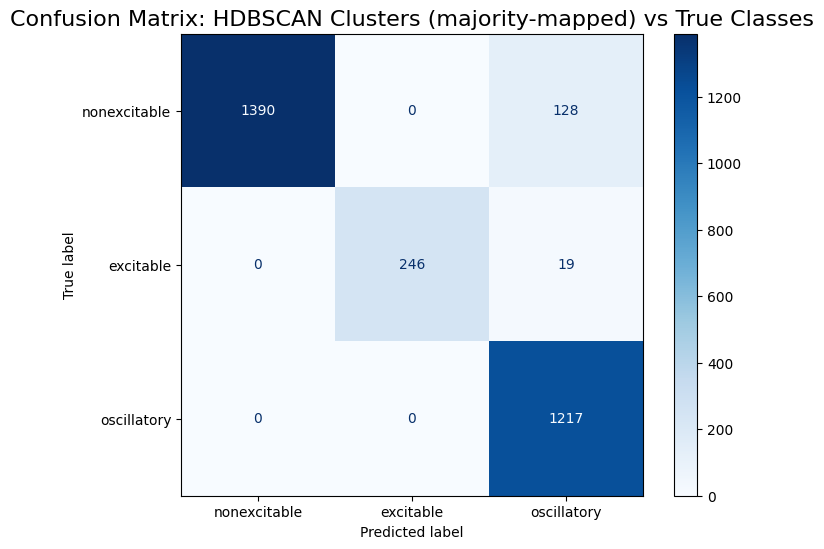


--- Part 3: Detailed Quantitative Report ---
Overall Clustering Accuracy (majority mapping): 95.10%

Class 'nonexcitable' (Total 1518):
  Correct: 1390 (91.57%)
  Misassigned as 'oscillatory': 128
------------------------------
Class 'excitable' (Total 265):
  Correct: 246 (92.83%)
  Misassigned as 'oscillatory': 19
------------------------------
Class 'oscillatory' (Total 1217):
  Correct: 1217 (100.00%)
------------------------------

--- Part 4: UMAP Visualization Colored by HDBSCAN Clusters ---


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


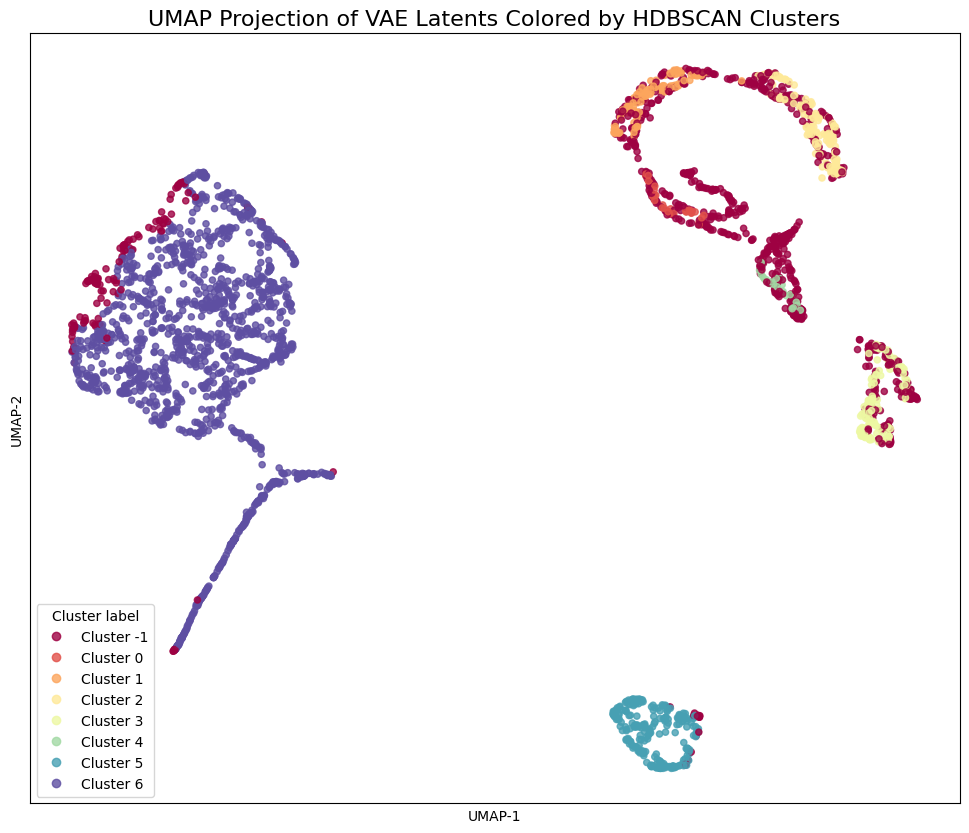


--- Part 5 (Modified): Average Voltage Traces for All HDBSCAN Clusters (excluding noise) ---
All clusters by size: [(np.int64(6), np.int64(1390)), (np.int64(5), np.int64(246)), (np.int64(2), np.int64(172)), (np.int64(3), np.int64(154)), (np.int64(1), np.int64(124)), (np.int64(0), np.int64(48)), (np.int64(4), np.int64(38))]


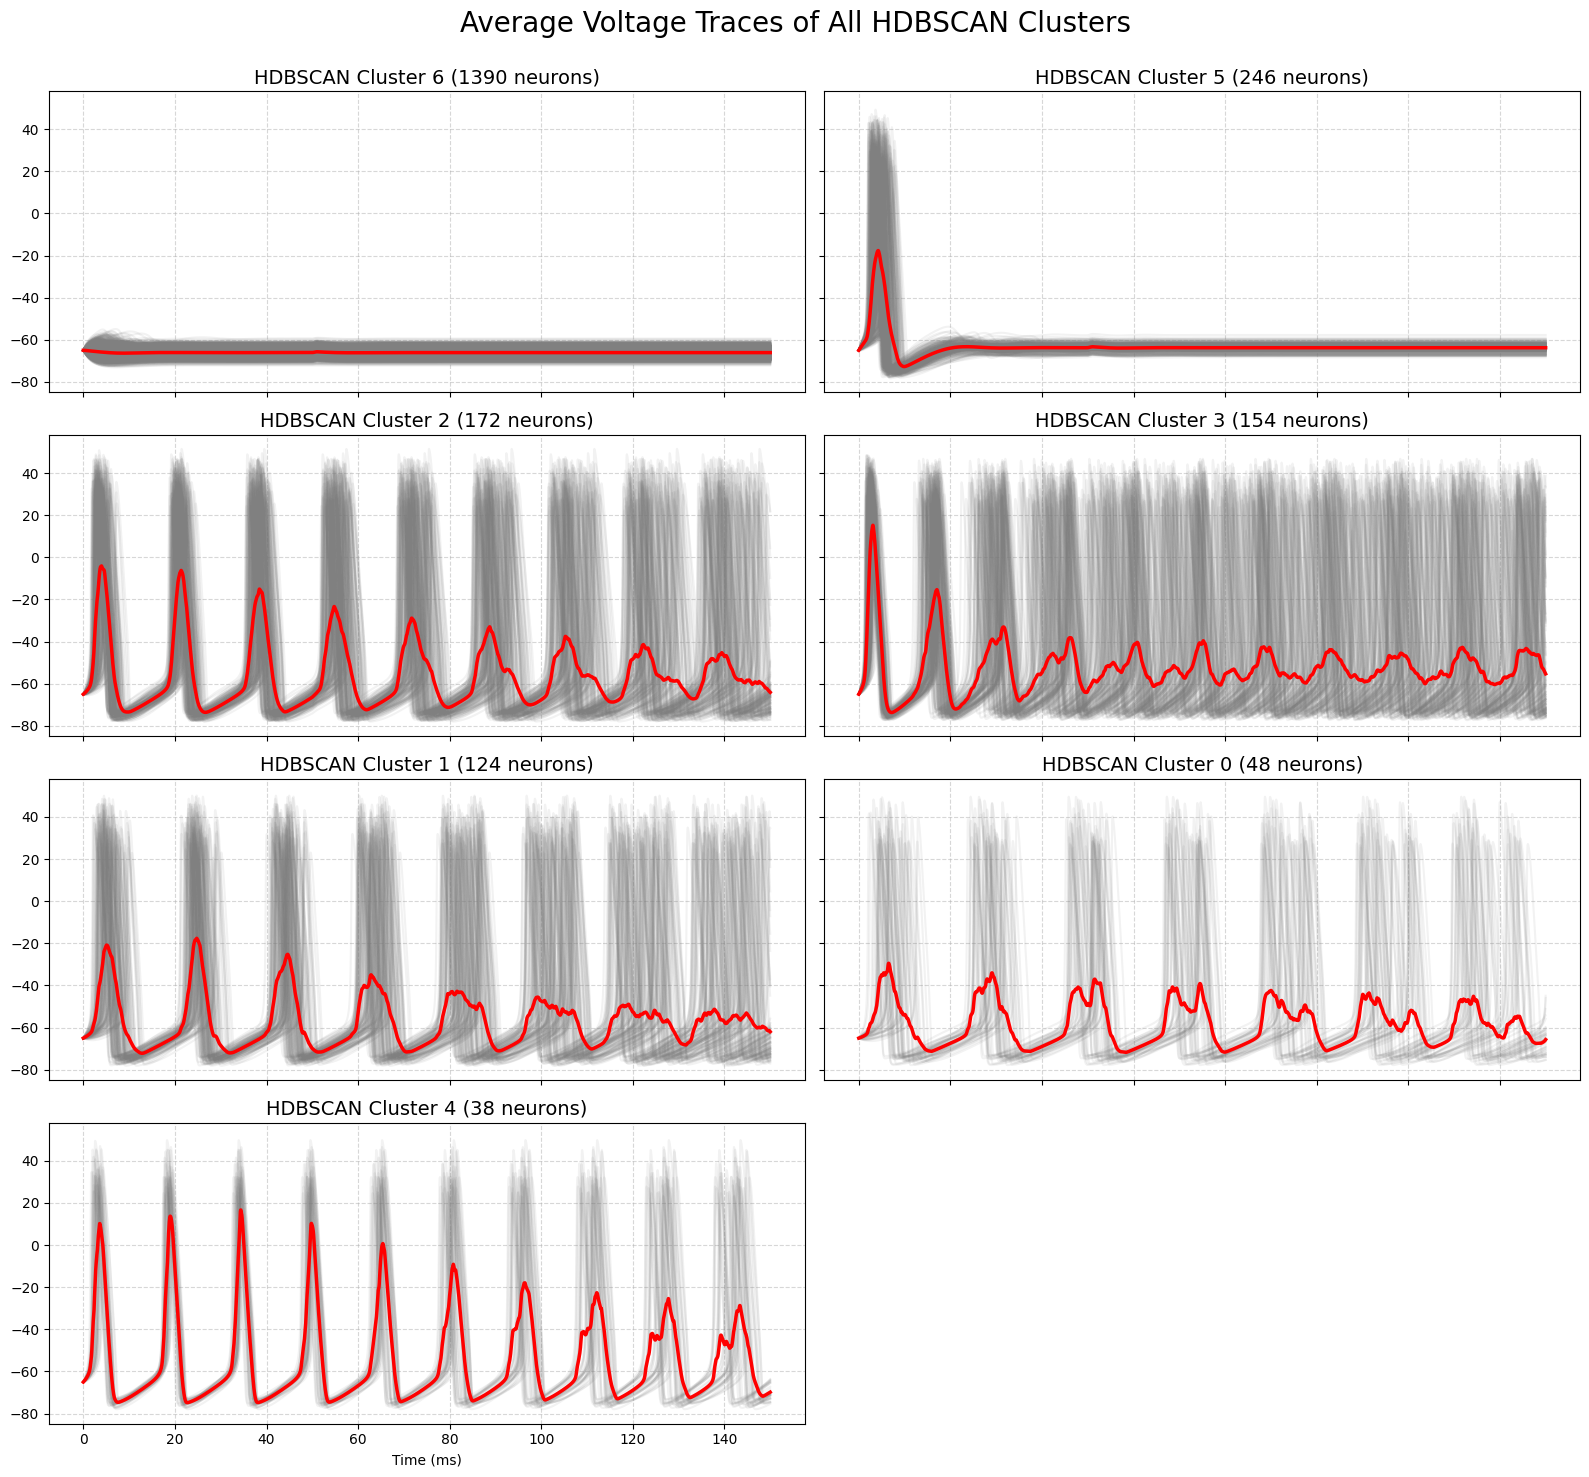

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import umap
import hdbscan

print("--- Part 0: Loading VAE Latent Space and Ground-Truth Labels ---")

try:
    features_for_clustering = np.load("/content/wst_S1_dynamic_vae_latents.npy")
    df_traces = pd.read_csv("voltage___traces2345.csv", index_col="time")
except FileNotFoundError as e:
    print("ERROR: Required file missing.")
    print(e)
    raise SystemExit

class_names = ["nonexcitable", "excitable", "oscillatory"]
ground_truth_labels_int = np.array([int(col.split('_group')[-1]) for col in df_traces.columns])

print(f"Loaded latent space: {features_for_clustering.shape}")
print(f"Loaded labels: {len(ground_truth_labels_int)}\n")

print("--- Part 1: HDBSCAN Clustering on VAE Latent Space ---")

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=30,
    min_samples=10,
    metric="euclidean",
    cluster_selection_method="eom"
)
cluster_labels = clusterer.fit_predict(features_for_clustering)

unique_labels = np.unique(cluster_labels)
n_clusters = np.sum(unique_labels >= 0)
n_noise = np.sum(cluster_labels == -1)

print(f"Found {n_clusters} clusters, with {n_noise} noise points (label = -1).")

print("\n--- Part 2: Map HDBSCAN Clusters to True Classes (Majority Vote) ---")

pred_labels_from_clusters = np.zeros_like(cluster_labels)

for cl in unique_labels:
    idx = np.where(cluster_labels == cl)[0]
    if len(idx) == 0:
        continue
    true_sub = ground_truth_labels_int[idx]
    counts = np.bincount(true_sub, minlength=len(class_names))
    majority_class = np.argmax(counts)
    pred_labels_from_clusters[idx] = majority_class
    if cl == -1:
        print(f"Noise cluster (-1): size={len(idx)}, majority true class={class_names[majority_class]}")
    else:
        print(f"Cluster {cl}: size={len(idx)}, majority true class={class_names[majority_class]}")

cm = confusion_matrix(ground_truth_labels_int, pred_labels_from_clusters)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format="d")
ax.set_title("Confusion Matrix: HDBSCAN Clusters (majority-mapped) vs True Classes", fontsize=16)
plt.show()

print("\n--- Part 3: Detailed Quantitative Report ---")
overall_acc = accuracy_score(ground_truth_labels_int, pred_labels_from_clusters)
print(f"Overall Clustering Accuracy (majority mapping): {overall_acc:.2%}\n")

for i in range(len(class_names)):
    total = np.sum(cm[i, :])
    correct = cm[i, i]
    acc_i = (correct / total) * 100 if total > 0 else 0
    print(f"Class '{class_names[i]}' (Total {total}):")
    print(f"  Correct: {correct} ({acc_i:.2f}%)")
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            print(f"  Misassigned as '{class_names[j]}': {cm[i, j]}")
    print("-" * 30)

print("\n--- Part 4: UMAP Visualization Colored by HDBSCAN Clusters ---")

reducer = umap.UMAP(n_neighbors=25, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(features_for_clustering)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    embedding[:, 0], embedding[:, 1],
    c=cluster_labels,
    cmap="Spectral",
    s=20,
    alpha=0.8
)
plt.title("UMAP Projection of VAE Latents Colored by HDBSCAN Clusters", fontsize=16)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.xticks([])
plt.yticks([])
handles, legend_labels = scatter.legend_elements()
labels_for_legend = [f"Cluster {int(l)}" for l in np.unique(cluster_labels)]
plt.legend(handles, labels_for_legend, title="Cluster label", loc="best")
plt.show()

print("\n--- Part 5 (Modified): Average Voltage Traces for All HDBSCAN Clusters (excluding noise) ---")

time_vector = df_traces.index.values
all_traces = df_traces.values

valid_clusters = [cl for cl in unique_labels if cl >= 0]
sizes = [(cl, np.sum(cluster_labels == cl)) for cl in valid_clusters]
sizes_sorted = sorted(sizes, key=lambda x: x[1], reverse=True)
all_clusters = [cl for cl, sz in sizes_sorted]

print("All clusters by size:", sizes_sorted)

n_clusters_to_plot = len(all_clusters)
ncols = 2
nrows = (n_clusters_to_plot + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(16, nrows * 4), sharex=True, sharey=True)
axes = axes.flatten()

for i, cl in enumerate(all_clusters):
    ax = axes[i]
    idx = np.where(cluster_labels == cl)[0]

    if len(idx) == 0:
        ax.set_title(f"HDBSCAN Cluster {cl} (Empty)")
        continue

    traces = all_traces[:, idx]
    mean_trace = traces.mean(axis=1)

    ax.plot(time_vector, traces, color="gray", alpha=0.1)
    ax.plot(time_vector, mean_trace, color="red", linewidth=2.5)
    ax.set_title(f"HDBSCAN Cluster {cl} ({len(idx)} neurons)", fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.5)

for j in range(n_clusters_to_plot, len(axes)):
    axes[j].axis("off")

axes[-2].set_xlabel("Time (ms)")
axes[-1].set_xlabel("Time (ms)")

fig.suptitle("Average Voltage Traces of All HDBSCAN Clusters", fontsize=20, y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
